In [1]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
model_paths = ["Save_File/seperate_model_best_05_28/A/checkpoints/epoch=39-step=1199.ckpt",
                "Save_File/seperate_model_best_05_28/B/checkpoints/epoch=57-step=1739.ckpt",
                "Save_File/seperate_model_best_05_28/C/checkpoints/epoch=41-step=1259.ckpt",
                "Save_File/seperate_model_best_05_28/D/checkpoints/epoch=44-step=1349.ckpt",
                "Save_File/seperate_model_best_05_28/E/checkpoints/epoch=40-step=1229.ckpt"]

input_length = 48
output_length = 6

dataframes = []

group_name = ["A", "B", "C", "D", "E"]

for i in range(len(group_name)):
    dataset = pd.read_csv(f"Refined_Data/Grouped_Data/{group_name[i]}.csv", index_col=0)
    dataframes.append(dataset)

In [3]:
group = [
    [34, 40, 42, 41, 4, 10, 11, 12],
    [35, 6, 48, 27, 57, 8, 25, 56, 26, 55, 47, 13, 53, 18, 7, 17, 46],
    [31, 33, 9, 3, 1, 32],
    [29, 38, 43, 58, 15, 22, 39, 54, 23, 44, 45, 37, 52, 2, 14],
    [21, 19, 50, 49, 20, 51, 30, 36, 28, 59, 5, 60, 16, 24]
]

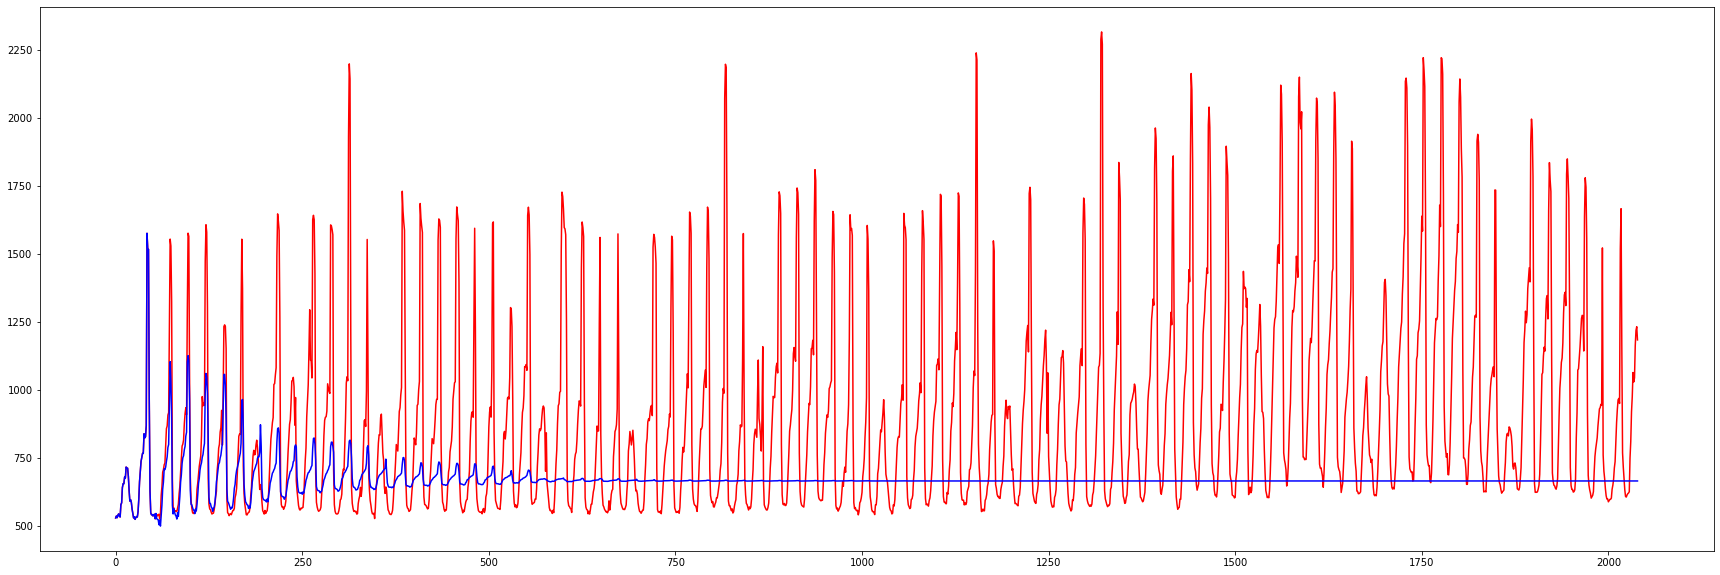

In [4]:
for i in range(len(model_paths)):
    now_dataframe = dataframes[i]
    now_dataframe['num'] = now_dataframe['num'].apply(str)
    now_dataframe['energy_group'] = now_dataframe['energy_group'].apply(str)
    now_dataframe['Week'] = now_dataframe['Week'].apply(str)
    now_dataframe['24Hour'] = now_dataframe['24Hour'].apply(str)
    
    now_best_tft = TemporalFusionTransformer.load_from_checkpoint(model_paths[i])

    for building in group[i]:
        now_building_dataframe = now_dataframe.loc[now_dataframe["num"] == str(building)].copy()

        original = now_building_dataframe.iloc[0:input_length+output_length]["kWH"].tolist()
        prediction = now_building_dataframe.iloc[0:input_length+output_length]["kWH"].tolist()  

        total_cycle = (len(now_building_dataframe) - input_length - output_length) // output_length

        for k in range(total_cycle):
            now_start_point = k*output_length

            encoder_data = now_building_dataframe.iloc[now_start_point:now_start_point+input_length].copy()
            decoder_data = now_building_dataframe.iloc[now_start_point+input_length:now_start_point+input_length+output_length].copy()
            new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

            raw_predictions = now_best_tft.predict(new_prediction_data, mode="prediction").numpy().tolist()[0]
            originals = now_building_dataframe.iloc[now_start_point+input_length : now_start_point+input_length+output_length]["kWH"].tolist()

            prediction.extend(raw_predictions)
            original.extend(originals)

            # for next step, change dataframe's original value to predicted value
            for p in range(output_length):
                now_building_dataframe.iloc[now_start_point+input_length+p, now_building_dataframe.columns.get_loc("kWH")] = raw_predictions[p]
            
        plt.rcParams["figure.figsize"] = (30,10)
        fig = plt.figure()
        graph = fig.add_subplot(1, 1, 1)
        graph.plot(original, color='red')
        graph.plot(prediction, color='blue')
        plt.show()

        break
    break